In [1]:
import pandas as pd
from pandas import DataFrame
import os

%load_ext google.cloud.bigquery

In [2]:
from google.cloud import bigquery

credential_path = r'../../BQ_Keypath/portfolio-331917-9f920a11ce56.json'
client = bigquery.Client.from_service_account_json(credential_path)

# define helper functions
def getQueryAsDF(query):
    return client.query(query).result().to_dataframe()

def getTableSchema(table):
    return client.get_table(table).schema

What are the total count for gold badges given and overal %?

In [3]:
# first, let look at the badges table schema
schema = getTableSchema("bigquery-public-data.stackoverflow.badges")
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('class', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('tag_based', 'BOOLEAN', 'NULLABLE', None, (), None)]

class field identifies badges type: 1 - gold, 2 - silver, 3 - bronze

In [4]:
# total count for gold badges earned
query = """
        SELECT
            COUNT(*) AS total_count
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE
            class = 1;
    """

result = getQueryAsDF(query)
result

total_count
0      1175600

In [5]:
# % of gold badge users vs non-gold badge users
query = """
        SELECT 
            ROUND((SELECT COUNT(DISTINCT user_id) FROM `bigquery-public-data.stackoverflow.badges` WHERE class = 1)/COUNT(DISTINCT user_id), 3) * 100 AS gold_badge_users_perc
        FROM `bigquery-public-data.stackoverflow.badges`
    """

result = getQueryAsDF(query)
result

gold_badge_users_perc
0                    6.4

In [6]:
# % of gold badges earned overall
query = """
        SELECT
            ROUND(COUNT(*) /(SELECT COUNT(*) FROM `bigquery-public-data.stackoverflow.badges`), 3) * 100 AS total_perc
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE
            class = 1;
    """

result = getQueryAsDF(query)
result

total_perc
0         2.8

That is a really low % of badges given are gold. Which can indicate gold badges are tough to earn. 

For non-gold badge user like myself, I would like to know what are the top ten earned gold badges that I can aim for?

In [7]:
query = """
        SELECT 
            name,
            COUNT(*) as badge_total_count
        FROM `bigquery-public-data.stackoverflow.badges`
        WHERE 
            class = 1
        GROUP BY 1
        ORDER BY badge_total_count DESC
        LIMIT 10;
    """

result = getQueryAsDF(query)
result

name  badge_total_count
0   Famous Question             849358
1      Great Answer              98716
2    Great Question              46519
3           Fanatic              39568
4          Populist              25556
5       Unsung Hero              25468
6        Electorate              25369
7           Steward              21414
8         Publicist               9682
9  Stellar Question               9215

There is approximately 12x jump from Great Answer badge to the Famous Question badge earned. Based on Stackoverflow docummentation, Famous Question is earned by having 10k+ views and can be earn multiple times. This resulted in a single user has multiple Famous Question badges and drive up the different in the jump. 

Ranking by tenure(by year joined), how many users earned gold badges based on the year? 

My hypothesis is the more tenure a user is, the more gold badges they will earn.

In [8]:
# we will be joining users table next. First, let look at its schema to see what are the field we will be using.
schema = getTableSchema("bigquery-public-data.stackoverflow.users")
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, (), None)]

In [7]:
# we can join the user_id field from the badges table and id field from the users table
query = """
        SELECT 
            EXTRACT (YEAR FROM creation_date) as year_joined,
            COUNT(DISTINCT user_id) as gold_badge_user_count
        FROM 
            `bigquery-public-data.stackoverflow.badges` AS badges
            JOIN `bigquery-public-data.stackoverflow.users` AS users ON users.id = badges.user_id
        WHERE 
            class = 1
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;
    """

result = getQueryAsDF(query)
result

year_joined  gold_badge_user_count
0         2012                  76952
1         2013                  72933
2         2011                  70643
3         2010                  48735
4         2014                  48536
5         2015                  37463
6         2009                  32026
7         2016                  28233
8         2017                  18772
9         2008                  13468

As shown in the result, users, who joined in 2011 - 2013, are the largest population with gold badge/s earned. Eventhough, 2008-2009 group has the most tenure, they are on the lower end of the table. This can be a correlation to when Stackoverflow was found(2008). Users population might be much smaller in size during the first couple of years after the platform launched. 

We can use a visual aid from Seaborn library to see the population size over the years.

Text(0.5, 1.0, 'Gold Badge User Count by Year Joined')

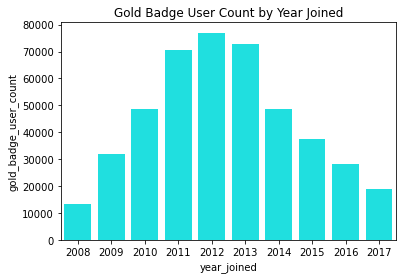

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plot = sns.barplot(data = result, x = 'year_joined', y = 'gold_badge_user_count', color = 'cyan')
plot.set_title('Gold Badge User Count by Year Joined')

Unintendedly, we have a normal distribution of gold badge users joined by year. Peak users count top out in 2012. From a business standpoint, it would be great to know what are the retention rate of the gold badge users vs general population in 2020. 

How many users are still active as of 2020? We will exclude 2021 since the complete data set is not yet available as of this time. 
- being active is defined by posting at least 1 question, comment or an answer.
- To be included, user must signed up on or before 2019. 
- We also excluding last_access_date field from users table since we do not know whether a user is actively engage when logged in. 

In [11]:
query = """
        WITH 
        total_active_user AS 
        (
            SELECT 
                COUNT(DISTINCT id) AS active_user,
            FROM 
                `bigquery-public-data.stackoverflow.users`
            WHERE 
                EXTRACT(YEAR FROM creation_date) <= 2019
                AND (id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_questions` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_answers` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT user_id FROM `bigquery-public-data.stackoverflow.comments` WHERE EXTRACT(YEAR FROM creation_date) = 2020))
        ),

        total_joined AS
        (
            SELECT 
                COUNT(id) AS user_count
            FROM
                `bigquery-public-data.stackoverflow.users`
            WHERE
                EXTRACT(YEAR FROM creation_date) <= 2019
        )

        SELECT 
            (SELECT active_user FROM total_active_user) AS total_active,
            (SELECT user_count FROM total_joined) AS total_joined,
            ROUND((SELECT active_user FROM total_active_user)/(SELECT user_count FROM total_joined), 3) * 100 AS retention_rate

    """

result = getQueryAsDF(query)
result

total_active  total_joined  retention_rate
0        798881      11491305             7.0

We have an overall retention rate of 7% in 2020. Let break down by active/inactive and highest badge level earned.

In [12]:
query = """
        WITH active_users AS
        (
             SELECT 
                id
            FROM 
                `bigquery-public-data.stackoverflow.users`
            WHERE 
                EXTRACT(YEAR FROM creation_date) <= 2019
                AND (id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_questions` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_answers` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT user_id FROM `bigquery-public-data.stackoverflow.comments` WHERE EXTRACT(YEAR FROM creation_date) = 2020))
        )

        SELECT 
            CASE -- order here matter, gold -> silver -> bronze
                WHEN id IN (SELECT user_id FROM `bigquery-public-data.stackoverflow.badges` WHERE class = 1)  THEN "Gold"
                WHEN id IN (SELECT user_id FROM `bigquery-public-data.stackoverflow.badges` WHERE class = 2)  THEN "Silver"
                ELSE "Bronze"
            END AS class,
            CASE
                WHEN id IN (SELECT id FROM active_users) THEN 1
                ELSE 0
            END AS is_active,
            COUNT(id) AS total
        FROM `bigquery-public-data.stackoverflow.users`
        GROUP BY 1,2
        ORDER BY 1;
    """

result = getQueryAsDF(query)
result

class  is_active     total
0  Bronze          0  13597067
1  Bronze          1    384164
2    Gold          0    307534
3    Gold          1    157530
4  Silver          0    835463
5  Silver          1    257187

In [13]:
# re-organizing result
data_dict = {
    'class': result['class'].unique(),
    'active': result[result['is_active'] == 1]['total'].values,
    'total': result[result['is_active'] != 1]['total'].values
}
df = pd.DataFrame(data_dict)
df['rr_perc'] = round(df['active']/(df['active'] + df['total']),3) * 100

In [14]:
df

class  active     total  rr_perc
0  Bronze  384164  13597067      2.7
1    Gold  157530    307534     33.9
2  Silver  257187    835463     23.5

Even though Gold badge users group is the smallest group, they have the highest retention rate of 33.9% in 2020 compare to 2.7% of bronze group.

For further analysis, we can see if there is a correlation between users tenure and number of badges earned among the active users.

In [30]:
query = """
        WITH badge_earned AS
        (
            SELECT 
                user_id,
                COUNT(id) AS num_badges 
            FROM `bigquery-public-data.stackoverflow.badges` 
            GROUP BY 1
        ),

        active_users AS
        (
            SELECT 
                id,
                reputation,
                creation_date
            FROM 
                `bigquery-public-data.stackoverflow.users`
            WHERE 
                EXTRACT(YEAR FROM creation_date) <= 2019
                AND (id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_questions` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT owner_user_id FROM `bigquery-public-data.stackoverflow.posts_answers` WHERE EXTRACT(YEAR FROM creation_date) = 2020)
                OR id IN (SELECT user_id FROM `bigquery-public-data.stackoverflow.comments` WHERE EXTRACT(YEAR FROM creation_date) = 2020))
        )

        SELECT 
            id,
            reputation,
            EXTRACT(YEAR FROM creation_date) AS year_joined,
            num_badges
        FROM active_users AS users
            JOIN badge_earned ON users.id = badge_earned.user_id
        ORDER BY num_badges DESC;
    """

result = getQueryAsDF(query)
result.sample(10)

id  reputation  year_joined  num_badges
418315   7946215         202         2017           7
91530    1337057        1828         2012          40
353455   1840473         155         2012           9
657930  11802748           3         2019           2
474267  10814749          33         2018           6
373299   7033337         121         2016           8
255869   5692163         131         2015          14
504570   9420920          55         2018           5
90367    1127200        1674         2012          40
451815   9971068          23         2018           6

In [34]:
df = result.drop('id', axis = 1)
df.sample(5)

reputation  year_joined  num_badges
303980         315         2014          11
676855         131         2014           2
573629          47         2013           4
179603       14042         2008          21
115589         711         2009          33

In [40]:
corr = df.corr()
corr

reputation  year_joined  num_badges
reputation     1.000000    -0.176470    0.811418
year_joined   -0.176470     1.000000   -0.320405
num_badges     0.811418    -0.320405    1.000000

Text(0.5, 1.0, 'User Fields Correlation')

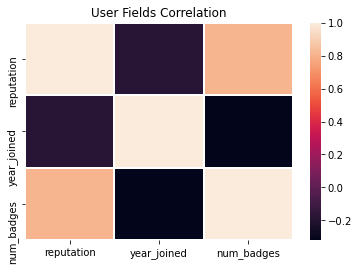

In [41]:
sns.heatmap(data = corr, linewidths = 1)
plt.title('User Fields Correlation')

This is an interesting find. Surprisingly, there is no correlation between tenure and number of badges earned. My assumption was the longer the tenure the more badges a user earned. However, there is a high correlation between reputation point and number of badges earned. 

Based on stacks overflow documentation, "Reputation is a rough measurement of how much the community trusts you; it is earned by convincing your peers that you know what youâ€™re talking about."

Let explore another visualization by plotting number of badges earned and user reputation.

Text(0.5, 0, 'reputation x 1 million')

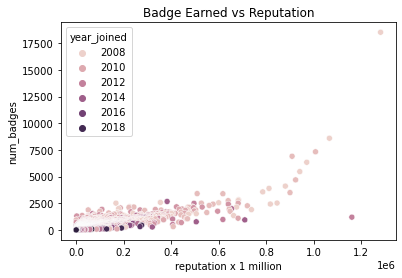

In [48]:
sns.scatterplot(x = 'reputation', y = 'num_badges', data = result, hue = 'year_joined')
plt.title('Badge Earned vs Reputation')
plt.xlabel('reputation x 1 million')

Notice there is a single user, who joined in 2008, that earned 17500+ badges, 18542 badges to be exact. Maybe this person is a trophies collector. This is an outlier in the data as the next highest badges earned is 8601. On the other end, another outlier is a user with the 2nd highest reputation, joined in 2012, has a very low badges earned count(1198).

Only a very small group of people have 800k+ of reputation and ~2.5k+ badges earned